In [1]:
import torch
import pickle
import numpy as np
import sys
sys.path.append('./../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML
from matplotlib import style
#rc('animation', html='html5')

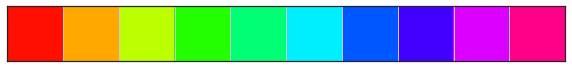

In [3]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

#current_palette = sns.color_palette(sns.hls_palette(10+1, l=.5, s=1.0))
#current_palette = sns.color_palette(sns.hls_palette(21+1, l=.5, s=1.0))
current_palette = sns.color_palette(sns.hls_palette(10, l=.5, s=1.0))


#current_palette = sns.palplot(sns.hls_palette("bright", l=.5, s=1.0))
#current_palette = np.asarray(sns.color_palette("deep"))
#current_palette[0] 
base_c = [0.00784314, 0.24313725, 1. ]

sns.palplot(current_palette)


In [4]:
from utility.dataset import _process_Synthetic
from models_utility.construct_models import _combine_models
from utility.eval_metric import _measure_metric, accuracy
#torch.set_default_tensor_type(torch.FloatTensor)




file_path = './dataset/synthetic/'
file_name = 'Q6_Fs1000'
data_file_path = file_path + file_name


##############################################################################
# load dataset
##############################################################################
random_seed = 1000
num_exp = 2


###############################################
###############################################

exp_setting = {}
exp_setting['device'] = False

exp_setting['num_rep_exp'] = num_exp
exp_setting['data'] = file_name
exp_setting['full_length'] = 100

exp_setting['input_dim'] = 1
exp_setting['Num_HiddenState'] = 8
exp_setting['Num_Q'] = 6



x_train, y_train, z_train, x_test, y_test, z_test, true_freq, true_weight, true_noise_level, true_num_state = _process_Synthetic(data_file_path, exp_setting)
exp_setting['input_length'] = x_train.shape[1]


In [5]:
print('#' * 100)
print('(#sequences, #time-series observations)')
print('xtrain.shape {}, ytrain.shape {}, xtest.shape {}, ytest.shape {}'.format(x_train.shape,y_train.shape,x_test.shape,y_test.shape))

####################################################################################################
(#sequences, #time-series observations)
xtrain.shape (100, 1000), ytrain.shape (100, 1000), xtest.shape (50, 1000), ytest.shape (50, 1000)


In [6]:
###############################################################################################
# Model Setting
###############################################################################################


HMMGP_setting = {}
HMMGP_setting['emission'] = 'gprrff_beta' #
HMMGP_setting['Num_Q'] = exp_setting['Num_Q']


#HMMGP_setting['train'] = 'VBEM' #
HMMGP_setting['train'] = 'SVI' #
HMMGP_setting['lr_A'] = 0.05
HMMGP_setting['lr_pi'] = 0.05
HMMGP_setting['lr_hyp'] = 0.005 #for beta


HMMGP_setting['Len_Full'] = exp_setting['full_length']
if HMMGP_setting['train'] == 'VBEM':
    HMMGP_setting['Len_Batch'] = HMMGP_setting['Len_Full']
    HMMGP_setting['Num_Batch'] = 1
else:
    HMMGP_setting['Len_Batch'] = 10
    HMMGP_setting['Num_Batch'] = 1


HMMGP_setting['Iter_train'] = 50 #for beta
HMMGP_setting['Iter_hyp'] = 10 #for beta


HMMGP_setting['Rate_RRFFSpectralPt'] = 0.1
HMMGP_setting['Num_RRFFSpectralPt_total'] = int((exp_setting['input_length'] * HMMGP_setting['Rate_RRFFSpectralPt']))
HMMGP_setting['Num_RRFFBatch'] = 1
HMMGP_setting['Num_K_Emission'] = 3



HMMGP_setting['device'] = exp_setting['device']


# print('input_length : %d'%(exp_setting['input_length']))
# print('Num_RRFFSpectralPt : %d'%(int ( (exp_setting['input_length']*HMMGP_setting['Rate_RRFFSpectralPt']) )))
# print('train : %s, emission : %s, num Q : %d, total spt: %d, rate : %.2f'
#       %(HMMGP_setting['train'],HMMGP_setting['emission'],HMMGP_setting['Num_Q'],HMMGP_setting['Num_RRFFSpectralPt_total'],HMMGP_setting['Rate_RRFFSpectralPt']))



In [ ]:
print('model: hmmgpsm(Q={}), infer: {}+{}, #full-sequences:{}, #sub-sequences: {}, #totalspt: {} #sptPerQ: {}'.format(HMMGP_setting['Num_Q'],
                                                                                                    HMMGP_setting['train'],
                                                                                                    HMMGP_setting['emission'],
                                                                                                    HMMGP_setting['Len_Full'],
                                                                                                    HMMGP_setting['Len_Batch'],
                                                                                                    int((exp_setting['input_length'] * HMMGP_setting['Rate_RRFFSpectralPt'])),
                                                                                                    int((exp_setting['input_length'] * HMMGP_setting['Rate_RRFFSpectralPt'])/HMMGP_setting['Num_Q']) ))


num_emission_param = exp_setting['Num_HiddenState']*(exp_setting['Num_Q']*(3*exp_setting['input_dim']) + 1 )
num_trasition_param = exp_setting['Num_HiddenState']**2 + exp_setting['Num_HiddenState']
num_modelparam = num_emission_param + num_trasition_param 
print('#model param : {}'.format(num_modelparam))

print('')

## build the model and intialize the hyperparameters

In [ ]:
model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 501)    

## train the model

In [9]:
# for i_th in range(exp_setting['num_rep_exp']):    
#     print('#' * 100)
#     model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 501)    
#     loglik_list, train_accuracy_list, test_accuracy_list, time_list, \
#     num_cluster_list, param_history_dict = model.train(x_train, y_train, z_train, x_test, y_test, z_test)


loglik_list, train_accuracy_list, test_accuracy_list, time_list, num_cluster_list, param_history_dict = model.train(x_train, y_train, z_train, x_test, y_test, z_test)


####################################################################################################
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
8
0 emission, 0 iter, loss 37617.1607 
0 emission, 50 iter, loss 15274.0307 
0 emission, 100 iter, loss 10581.0908 
0 emission, 150 iter, loss 7708.8039 
0 emission, 200 iter, loss 5589.9714 
0 emission, 250 iter, loss 4004.1848 
0 emission, 300 iter, loss 3082.1180 
0 emission, 350 iter, loss 1879.7748 
0 emission, 400 iter, loss 1701.4194 
0 emission, 450 iter, loss 1257.6788 
0 emission, 500 iter, loss 938.8889 

6
1 emission, 0 iter, loss 56421.9032 
1 emission, 50 iter, loss 10032.8854 
1 emission, 100 iter, loss 7430.2721 
1 emission, 150 iter, loss 5694.1369 
1 emission, 200 iter, loss 4088.8897 
1 emission, 250 iter, loss 2940.0827 
1 emission, 300 iter, loss 2030.7769 
1 emission, 

ValueError: too many values to unpack (expected 6)

In [10]:
tr_elbo, tr_lik, te_elbo, te_lik = loglik_list[:,0], loglik_list[:,1], loglik_list[:,2], loglik_list[:,3]
tr_bic = compute_bic(x_train,y_train,tr_lik[-1],num_modelparam)
te_bic = compute_bic(x_test,y_test,te_lik[-1],num_modelparam)

NameError: name 'loglik_list' is not defined

In [58]:
train_loglik_list.shape

(30, 4)

In [47]:
train_elbo,train_lik,test_elbo,test_lik = train_loglik_list[:,0],train_loglik_list[:,1],train_loglik_list[:,2],train_loglik_list[:,3]

In [62]:
train_elbo[-1],train_lik[-1],test_elbo[-1],test_lik[-1]

(-411606.07511556434,
 -68220.69071452697,
 -2963900.8274975438,
 -873405.9283146564)

In [63]:
figsiz2 = (20,2) 
labelsiz = 15
fontsiz = 20
interval = 0.2
xlimit_range = [105,145]

In [64]:
#z_test_pred = result_pickle['test_pred'][chosen_idx]
revised_order_dict, revised_z_test_pred, _ = _measure_metric(z_test, z_test_pred)
revised_z_test_pred = revised_z_test_pred

In [65]:
ith_z

3

## test set

No handles with labels found to put in legend.


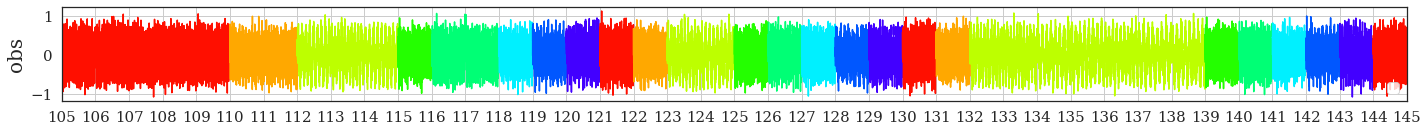

In [66]:

fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate(zip(x_test,y_test,z_test)):
    plt.plot( ith_x , ith_y , color = current_palette[ith_z])
    #plt.plot( ith_x , ith_y , color = current_palette[ith_z])
    #print(ith_x + ith)
    #plt.plot(ith + ith_x, ith_y , color = current_palette[ith_z])

#plt.title('true')
plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)

plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )
plt.yticks(fontsize = 15)

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

#plt.savefig(save_figure_path + model_name + '_true' + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()



## estimation for test set

No handles with labels found to put in legend.


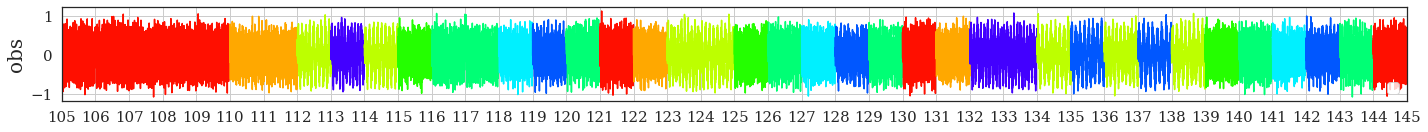

In [67]:
fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate( zip(x_test,y_test,revised_z_test_pred)):
#for ith,(ith_x,ith_y,ith_z) in enumerate( zip(x_test,y_test,z_test_pred)):
    plt.plot( ith_x , ith_y , color = current_palette[ith_z])

#    plt.plot( ith_x, ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
# plt.xlabel('time',fontsize = fontsiz)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )
plt.yticks(fontsize = 15)

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

#plt.savefig(save_figure_path + model_name + '_pred'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()


No handles with labels found to put in legend.


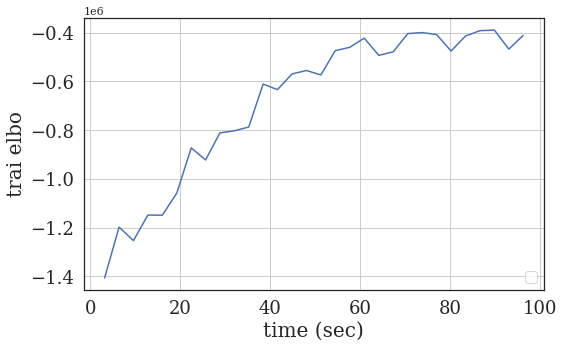

No handles with labels found to put in legend.


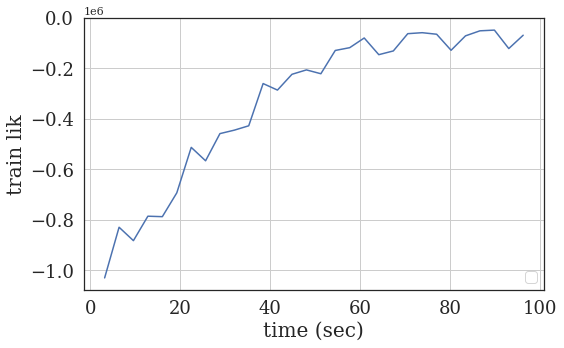

No handles with labels found to put in legend.


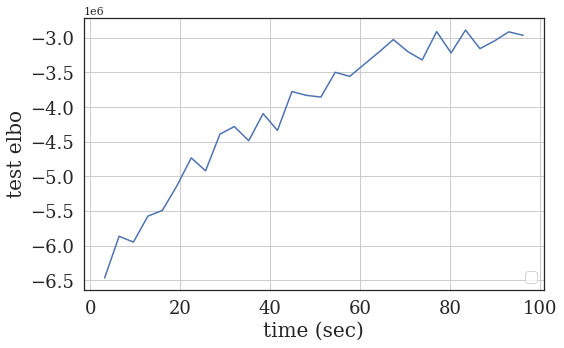

No handles with labels found to put in legend.


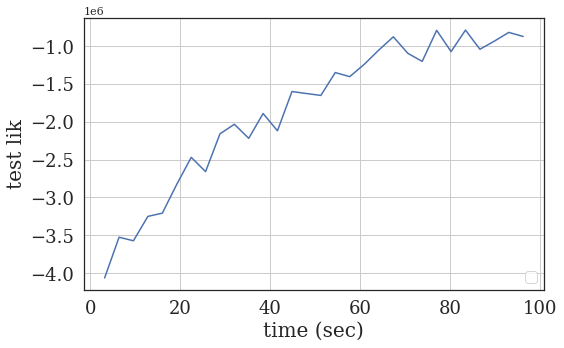

In [68]:
#train_loglik_list,train_accuracy_list, 
figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),train_elbo)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('trai elbo',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()

fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),train_lik)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('train lik',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),test_elbo)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('test elbo',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),test_lik)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('test lik',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()





No handles with labels found to put in legend.


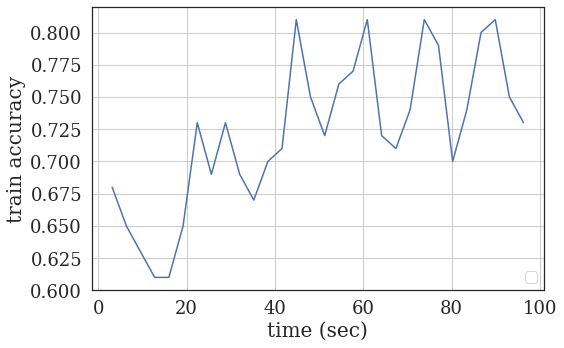

No handles with labels found to put in legend.


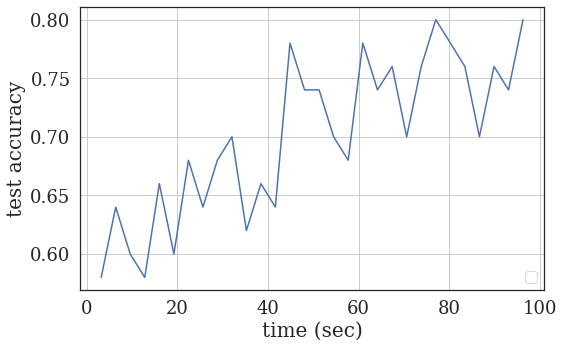

In [69]:
figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
plt.plot(time_list.cumsum(),train_accuracy_list)
#plt.xscale('log',basex=10) 
plt.ylabel('train accuracy',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
plt.plot(time_list.cumsum(),test_accuracy_list)
#plt.xscale('log',basex=10) 
plt.ylabel('test accuracy',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


## spectral density estimation 

/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


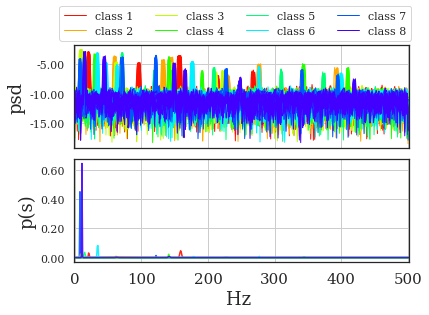

In [72]:
xlim_range = [0-1,500 + 1]

from scipy import signal
from scipy import  stats
from matplotlib.ticker import FormatStrFormatter



figsiz = (15,8) 
#figsiz = (6,3)
labelsiz = 15
fontsiz = 15
interval = 0.2

Fs = len(x_train[0])
fig,axs =  plt.subplots( 2, sharex=True , gridspec_kw={'hspace': 0.1})
ax1,ax2 = axs[0],axs[1]


for ith_z in range(10):
    #print(np.where(z_train==ith_z)[0][:3])
    for j,jth in enumerate(np.where(z_train==ith_z)[0][:]):
        freqs, psd = signal.welch(y_train[jth], fs= Fs ,nperseg= len(y_train[jth]) )        
        if j == 0:
            #ax1.plot(freqs, psd , color = current_palette[ith_z] , linewidth = 1 ,alpha = 1.0 ,label = 'class ' + str(ith_z + 1) )
            ax1.plot(freqs, np.log(psd+1e-8) , color = current_palette[ith_z] , linewidth = 1 ,alpha = 1.0 ,label = 'class ' + str(ith_z + 1) )
            
        else:
            #ax1.plot(freqs, psd , color = current_palette[ith_z] , linewidth = 1 , alpha = 1.0  )
            ax1.plot(freqs, np.log(psd+1e-8) , color = current_palette[ith_z] , linewidth = 1 , alpha = 1.0  )
    
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(bbox_to_anchor=(-0.05,1.02,1,0.1), loc="lower left", borderaxespad = 0.2 ,ncol = 4 ,fontsize = 11)
#ax1.legend(bbox_to_anchor=(1.04,0.5), loc="lower left", borderaxespad=0 ,ncol = 1 ,fontsize = 10)
fig.tight_layout()    
ax1.set_ylabel('psd',fontsize = 18)


#chosen_idx = 0
current_iter = HMMGP_setting['Iter_train']-1 
x = np.arange(512)
for ith_emission in range(exp_setting['Num_HiddenState']):
    a = 0
    for ith_weight,ith_mu,ith_std in zip(param_history_dict['weight'][current_iter][ith_emission],
                                         param_history_dict['mu'][current_iter][ith_emission],
                                         param_history_dict['std'][current_iter][ith_emission]) :
        a += .5*ith_weight* (stats.norm.pdf(x, ith_mu,ith_std**2) + stats.norm.pdf(x, -ith_mu ,ith_std**2))
    try : 
        ax2.plot(x, a , color = current_palette[revised_order_dict[ith_emission]] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*revised_order_dict[ith_emission]+1))        
        #ax2.plot(x, np.log(a+1e-8) , color = current_palette[revised_order_dict[ith_emission]] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*revised_order_dict[ith_emission]+1))        
        
    except:
        ax2.plot(x, a , color = current_palette[ith_emission] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*ith_emission+1))  
        #ax2.plot(x, np.log(a+1e-8) , color = current_palette[ith_emission] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*ith_emission+1))  
        
#ax2.set_ylim([0,0.6])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_xlabel('Hz ',fontsize = 18)
ax2.set_ylabel(r'p(s)',fontsize = 18)
plt.xticks(fontsize = 15)
plt.xlim(xlim_range)


fig.tight_layout()    
#plt.savefig(save_figure_path + model_name + '_psd_toegether'   + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
